# Lab Assignment Six: Convolutional Network Architectures

Minging Li, Jiayin Liu, Tianlei Xu, He Zhou  
  Apr.28, 2018

# 1. Preparation and Overview

## 1.1 Data Preparation

We use the Caltech 101 dataset in this project which is an established computer-vision dataset used for object recogintion. The dataset's train set consists of images of 16 objecct classes, and each class has different number of images.The dataset is particular collected for machine learning. 

In the lab, we aim to classify the images and attach label to each image. We use numbers to represent the label of each class and use it to calculate the corresponding accuracy scores. The labels of the variables have 10 classes: 'butterfly','crab','crayfish','crocodile','dolphin','elephant','leopard','lotus','panda','pigeon','rhion','rooster','scorpion','seahorse','starfish',and 'sunflower'. The orinial images have different pixels. So, first we reshape the images to the same size, visualize some of the images from each class, and then transfer them to gray scale. The train set contains 1078 images. 

In [4]:
import keras
from keras.datasets import cifar10
from scipy.misc import imresize
import numpy as np
from skimage import color,transform,io
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

keras.__version__
im = '/Users/jiayinliu/Desktop/study/ML/proj6/Newfolder/data/*.png'
images = io.ImageCollection(im)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


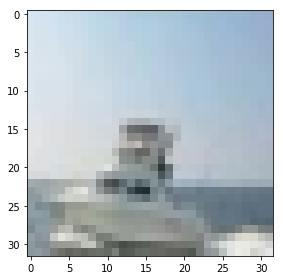

In [5]:
io.imshow(images[100])
plt.show()

In [6]:
def convert_gray(f):
    rgb = io.imread(f)
    gray=color.rgb2gray(rgb)  
    dst=transform.resize(gray,(32,32))
    dst = np.sqrt(dst / float(np.max(dst)))  
    return dst
Images =io.ImageCollection(im,load_func=convert_gray)

In [7]:
images_1d = np.zeros((len(Images),\
                      Images[0].shape[0] * Images[0].shape[1]))

for i in range(len(Images)):
    images_1d[i] = Images[i].ravel()

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


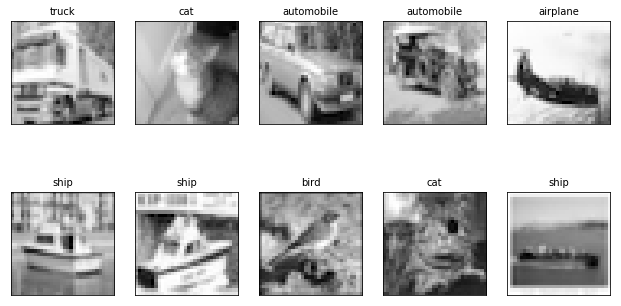

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

Label = pd.read_excel('/Users/jiayinliu/Desktop/study/ML/proj6/Newfolder/label.xlsx')
# a helper plotting function
def plot_gallery(images, titles,k,n_row=2, n_col=5):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        t=i*k+1
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[t].reshape((32,32)), cmap=plt.cm.gray)
        plt.title(titles[t], size=10)
        plt.xticks(())
        plt.yticks(())

plot_gallery(Images, Label['label'],100)

## 1.2 Evaluation Metrics

We will use accuracy as the metric to judge the performance of our model. Accuracy refers to the closeness of a measured value to a known value. In our case, we mean the proportion of correct results that a classifier achieved. The possible classification cases include 4 cases. Either the classifier got a positive example labeled as positive (true positive), or it made a mistake and marked it as negative (false negative). Conversely, a negative example may have been (mis)labeled as positive (false positive), or correctly guessed negative (true negative). Accuracy is the proportion of the total true positive and true negative numbers in the total classification numbers. In the case of unbalanced prediction, such as 0 predicted positive or 0 predicted negative, accuracy would not be a good indicator of model performance. Precision, recall, or F-score would be good metrics. But in our case, our data are almost balanced, which means each class contains almost the same number of observations in the data set. The predicted matrics would also be balanced. Therefore, it is approapriate to use accuracy as our evaluation metric.

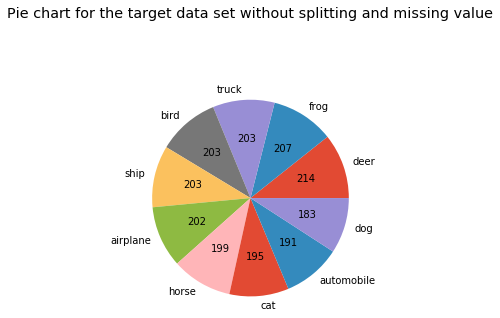

Number of instances in the binary classification problem: 2000


In [9]:
from sklearn.metrics import make_scorer,f1_score
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
y = Label['label']
y.replace(to_replace = ['deer','frog','truck','bird','ship','airplane','horse','cat','automobile','dog'],
                 value = range(10), inplace = True)
y = np.array(Label['label'])
# plot a pie chart of classes
labels = 'deer','frog','truck','bird','ship','airplane','horse','cat','automobile','dog'
img = Label['label']
sizes = [sum(img == 0), sum(img == 1), sum(img == 2), sum(img == 3),sum(img == 4),sum(img == 5),sum(img == 6),sum(img == 7),sum(img == 8),sum(img == 9)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct=lambda p: '{:.0f}'.format(p * len(img) / 100))
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie chart for the target data set without splitting and missing value', y=1.3)
plt.show()

print('Number of instances in the binary classification problem:', len(Label.label))

In [10]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

## 1.3 K-fold Cross Validation

We will use Stratified k-fold cross validation for dividing our data into training and testing data set.
The goal of performing cross-validation is to determine how well the CNN model fitting on our data set. We will use mean squared error (MSE) as the loss function, thus the actual estimate of the test MSE is of interest. When we use CNN to fit our data set, like other models, the fitting process optimize the model parameters to make the model fit the training data as well as possible. If we use independent samples of validation data and training data from the same data set, the model will usually fit training data very well, but will not fit the validation data as well as the training data. K-fold cross validation is a good method to solve this overfitting problem.

k-fold cross validation randomly dividing the set of observations into k folds of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k-1 folds. The MSE is then computed on the observations in the held-out fold. Each time, a different fold of observations is treated as a validation set, and the model is fit on the remaining k-1 folds. The procedure is repeated k times. This process results in k estimates of the test MSE. The k-fold CV estimate is computed by average of these values.

In practice, k-fold cross-validation is computationally feasible if k is 5 or 10 because it requires fitting the learning procedure only 5 or 10 times . Also 5 or 10-fold CV is a bias-variance trade-off, which will suffer neither from excessively high bias nor from very high variance.

# 2 Modeling

## 2.1 Create a Convolutional Neural Network

In [11]:

NUM_CLASSES = 10                   # 一共的类数
img_wh = 32                         # 图片的尺寸

X = np.expand_dims(images_1d.reshape((-1,img_wh,img_wh)), axis=3) 
y= keras.utils.to_categorical(y, NUM_CLASSES)

(2000, 32, 32, 1)


/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


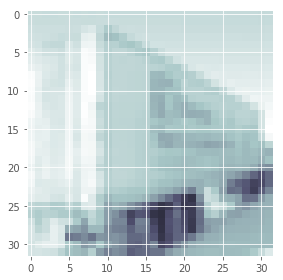

In [12]:
print(X.shape)
imshow(X[15].squeeze(),cmap='bone')
#print(y_train[0])

### Data Expansion

The difficulty with image recognition is to enable a machine to recognize objects and object categories in images. To get good image recognition model, plentiful labeled images are need to train the model. Data expansion increases the number of images to train the model. We use rotation, width and height shift, and size change in the data expansion. This method is appropriate for image recognition because after data expansion, the shape and boundary of an object in the image will still be the same as in the origial image. 

In [13]:
# expansion的方法
classes = ['deer','frog','truck','bird','ship','airplane','horse','cat','automobile','dog']

datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.2,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None)

datagen.fit(X)

idx = 0

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


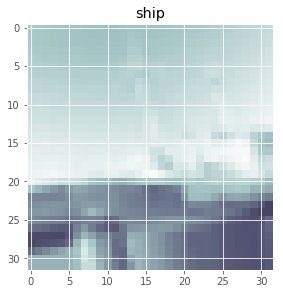

In [14]:
# expansion
tmps = datagen.flow(X, y, batch_size=1)

for tmp in tmps:
    imshow(tmp[0].squeeze(),cmap='bone')
    plt.title(classes[np.argmax(tmp[1])])
    break

In [15]:
tmps[1][0].shape  # y_tmp

(1, 32, 32, 1)

In [16]:
for i in range(len(tmps)):
    X = np.vstack((X, tmps[i][0]))
    y = np.vstack((y, tmps[i][1]))

In [17]:
X.shape

(4000, 32, 32, 1)

In [323]:
N = X.reshape(4000,1024)

In [324]:
y.shape

(4000, 10)

In [325]:
X, X_test, y, y_test = train_test_split(
    X , y, test_size=0.2, random_state=42)

## 2.2 Two Different CNN

We create a two layer CNN and 4 layer CNN and vasulize the performance of the training and validation sets per iteration for both convolutional network architectures. 

### 2.2.1 Two layers CNN

In [326]:
cnn = Sequential()

# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters = 32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters = 16,
                kernel_size = (4,4), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))


# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adadelta', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])


### 2.2.1.1 Cross Validtaion

In [329]:
from sklearn import cross_validation
k_fold = cross_validation.KFold(len(X),n_folds=5)

In [331]:
# 使用cross validation 进行验证
score = []
history = []
for k, (train, test) in enumerate(k_fold):    # 2可以换成任意数
    X_train =X[train]
    X_test = X[test]
    y_train_ohe = y[train]
    y_test_ohe = y[test]
    history_new = cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=10), 
                       steps_per_epoch=int(len(X_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(X_test,y_test_ohe)
                      )
    yhat = np.argmax(cnn.predict(X_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohe)):
        y_test.append(np.argmax(y_test_ohe[i]))
    
    y_test = np.array(y_test) 
    
    # 计算精度
    acc = mt.accuracy_score(y_test,yhat)
    score.append(score_new)
    history.append(history_new)

Epoch 1/10
256/256 [==============================] - 11s 42ms/step - loss: 0.0901 - acc: 0.0980 - val_loss: 0.0900 - val_acc: 0.0844
Epoch 2/10
256/256 [==============================] - 11s 41ms/step - loss: 0.0900 - acc: 0.1094 - val_loss: 0.0900 - val_acc: 0.1141
Epoch 3/10
256/256 [==============================] - 10s 40ms/step - loss: 0.0900 - acc: 0.1031 - val_loss: 0.0899 - val_acc: 0.0859
Epoch 4/10
256/256 [==============================] - 11s 42ms/step - loss: 0.0900 - acc: 0.1082 - val_loss: 0.0900 - val_acc: 0.0781
Epoch 5/10
256/256 [==============================] - 11s 41ms/step - loss: 0.0900 - acc: 0.1141 - val_loss: 0.0900 - val_acc: 0.0734
Epoch 6/10
256/256 [==============================] - 11s 44ms/step - loss: 0.0899 - acc: 0.1082 - val_loss: 0.0898 - val_acc: 0.1547
Epoch 7/10
256/256 [==============================] - 11s 42ms/step - loss: 0.0898 - acc: 0.1188 - val_loss: 0.0896 - val_acc: 0.1063
Epoch 8/10
256/256 [==============================] - 11s 42ms

### 2.2.1.2 History graph of 2 layer CNN

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


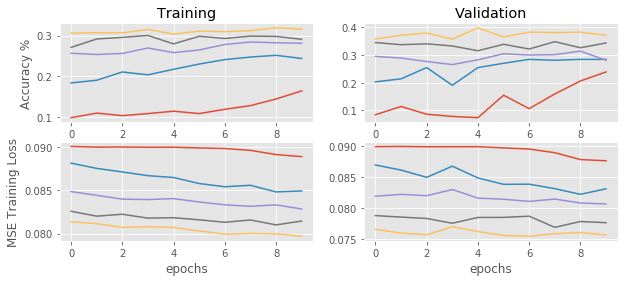

In [334]:
###  为什么training只有一条线
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

### 2.2.1.3 Visualize 2 Layers CNN

In [332]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn,X_test, y_test):
    plt.figure(figsize=(15,5))
    yhat_cnn = np.argmax(cnn.predict(X_test), axis=1)
    acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
    plt.subplot(1,2,1)
    cm = mt.confusion_matrix(y_test,yhat_cnn)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title('CNN: '+str(acc_cnn))

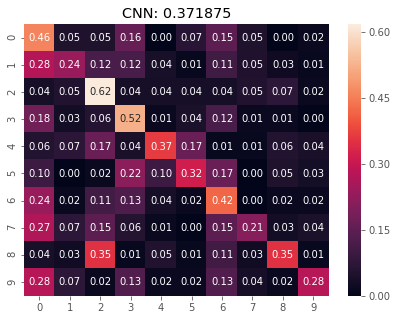

In [333]:
compare_mlp_cnn(cnn,X_test,y_test)

The accuracy for 2 layers CNN is 0.37. 


The MSE for the training data and validation is shown as above figure. As the iteration increase, the training error and the test error decrease until they are almost stable. The accuracy of the validation data is of our interest. The right above figure shows the accuracy of validation data increses as first and then remains stable. 

### 2.2.2 Four layers CNN

In [335]:
cnn1 = Sequential()

# let's start with an AlexNet style convolutional phase
cnn1.add(Conv2D(filters = 32,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn1.add(Conv2D(filters = 32,
                kernel_size = (4,4), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))

##########################################################################

cnn1.add(Conv2D(filters = 64,
                input_shape = (img_wh,img_wh,1),
                kernel_size=(4,4), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn1.add(Conv2D(filters = 64,
                kernel_size = (4,4), 
                padding='same', 
                activation='relu')) # more compact syntax

# add one layer on flattened output
##########################################################################

cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='mean_squared_error', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='adadelta', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

### CrossValidtaion

In [337]:
score = []
history = []
for k, (train, test) in enumerate(k_fold):    # 2可以换成任意数
    X_train =X[train]
    X_test = X[test]
    y_train_ohe = y[train]
    y_test_ohe = y[test]
    history_new = cnn1.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=10), 
                       steps_per_epoch=int(len(X_train)/10), # how many generators to go through per epoch
                       epochs=10, verbose=1,
                       validation_data=(X_test,y_test_ohe)
                      )
    yhat = np.argmax(cnn1.predict(X_test), axis=1)
    y_test = []
    for i in range(len(y_test_ohe)):
        y_test.append(np.argmax(y_test_ohe[i]))
    
    y_test = np.array(y_test) 
    
    # 计算精度
    acc = mt.accuracy_score(y_test,yhat)
    score.append(score_new)
    history.append(history_new)

Epoch 1/10
256/256 [==============================] - 29s 112ms/step - loss: 0.0891 - acc: 0.1555 - val_loss: 0.0870 - val_acc: 0.2391
Epoch 2/10
256/256 [==============================] - 29s 112ms/step - loss: 0.0881 - acc: 0.1832 - val_loss: 0.0854 - val_acc: 0.2516
Epoch 3/10
256/256 [==============================] - 28s 111ms/step - loss: 0.0874 - acc: 0.1973 - val_loss: 0.0855 - val_acc: 0.2234
Epoch 4/10
256/256 [==============================] - 28s 110ms/step - loss: 0.0870 - acc: 0.2137 - val_loss: 0.0863 - val_acc: 0.2031
Epoch 5/10
256/256 [==============================] - 28s 110ms/step - loss: 0.0865 - acc: 0.2109 - val_loss: 0.0836 - val_acc: 0.2609
Epoch 6/10
256/256 [==============================] - 28s 110ms/step - loss: 0.0859 - acc: 0.2207 - val_loss: 0.0829 - val_acc: 0.2781
Epoch 7/10
256/256 [==============================] - 29s 112ms/step - loss: 0.0854 - acc: 0.2262 - val_loss: 0.0811 - val_acc: 0.2906
Epoch 8/10
256/256 [==============================] - 2

### 2.2.2.1 History Graph of Four layers CNN

D:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


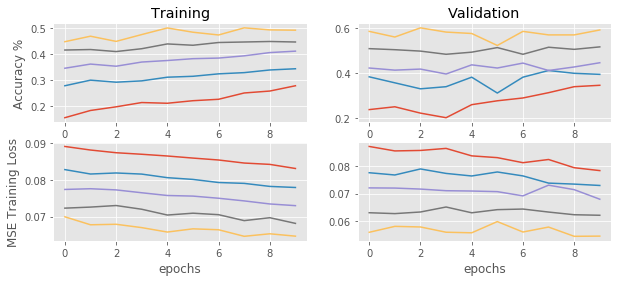

In [347]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
for i in range(len(history)):
    plt.plot(history[i].history['acc'])
    plt.ylabel('Accuracy %')
    plt.title('Training')

for i in range(len(history)):
    plt.subplot(2,2,2)
    plt.plot(history[i].history['val_acc'])
    plt.title('Validation')

for i in range(len(history)):
    plt.subplot(2,2,3)
    plt.plot(history[i].history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

for i in range(len(history)):
    plt.subplot(2,2,4)
    plt.plot(history[i].history['val_loss'])
    plt.xlabel('epochs')

The MSE for the training data and validation is shown as above figure. As the iteration increase, the training error and the test error decrease until they are close to 0.06. The accuracy of the training data stays about 0.50 as the iteration increases. The accuracy of the validation data is of our interest. The accuracy of validation data remains almost stable at about 0.60 as the iterations. 

## 2.3 Visualize CNN

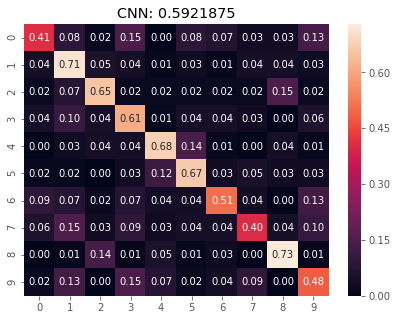

In [338]:
compare_mlp_cnn(cnn1,X_test,y_test)

The accuracy for 4 layers CNN is 0.59. The accuracy for 2 layers CNN is 0.37. The 4 layers CNN shows a better accuracy.

## 2.4 Compare CNN and MLP 

## 2.4.1 MLP

In [339]:
#y_train_ohe_mlp = keras.utils.to_categorical(y_train_mlp, NUM_CLASSES)
#y_test_ohe_mlp = keras.utils.to_categorical(y_test_mlp, NUM_CLASSES)

# make a 3 layer keras MLP

mlp = Sequential()
mlp.add( Dense(input_dim=X_train_mlp.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=16, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [340]:
#### MLP cross validation
score = []

for k, (train, test) in enumerate(k_fold):   
    X_train = X[train]
    X_test = X[test]
    y_train_ohe = y[train]
    y_test_ohe = y[test]
    mlp.fit(X_train_mlp, y_train_mlp, 
        batch_size=32, epochs=100, 
        shuffle = True, verbose=0)    

### 2.4.2 ROC Curve for MLP and CNN

In [341]:
# CNN curve
yhat = np.argmax(cnn.predict(X_test), axis=1)
yhat = keras.utils.to_categorical(yhat, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
fpr,tpr,threshold = roc_curve(y_test_ohe.ravel(), yhat.ravel())
roc_auc = auc(fpr,tpr)

In [342]:
# CNN1(layer) curve
yhat = np.argmax(cnn1.predict(X_test), axis=1)
yhat = keras.utils.to_categorical(yhat, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)
fpr1,tpr1,threshold1 = roc_curve(y_test_ohe.ravel(), yhat.ravel())
roc_auc = auc(fpr,tpr)

In [ ]:
# MLP curve
yhat_mlp = np.argmax(mlp.predict(X_test_mlp), axis=1)
yhat_mlp = keras.utils.to_categorical(yhat_mlp, NUM_CLASSES)
y_test_mlp = keras.utils.to_categorical(y_test, NUM_CLASSES)
fpr_mlp,tpr_mlp,threshold_mlp = roc_curve(y_test_mlp.ravel(), yhat_mlp.ravel())
roc_auc_mlp = auc(fpr_mlp,tpr_mlp)

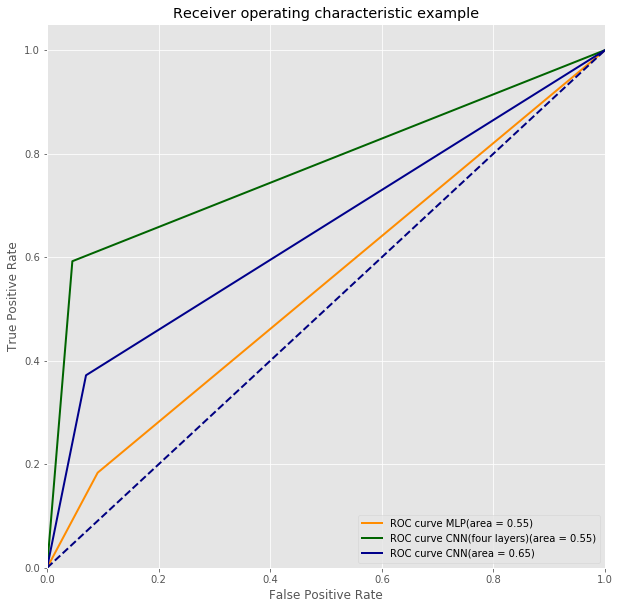

In [346]:
lw = 2  
plt.figure(figsize=(10,10)) 

plt.plot(fpr_mlp, tpr_mlp, color='darkorange',  
         lw=lw, label='ROC curve MLP(area = %0.2f)' % roc_auc_mlp) ###假正率为横坐标，真正率为纵坐标做曲线  
plt.plot(fpr1, tpr1, color='darkgreen',  
         lw=lw, label='ROC curve CNN(four layers)(area = %0.2f)' % roc_auc_mlp) ###假正率为横坐标，真正率为纵坐标做曲线  
plt.plot(fpr, tpr, color='darkblue',  
         lw=lw, label='ROC curve CNN(area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right")  
plt.show()  

The graph above shows that four layer CNN out competes the other two models overall. 

# Exceptional Work 

In [1]:
import keras
from keras.datasets import cifar10
from scipy.misc import imresize
import numpy as np
from skimage import color,transform,io
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

keras.__version__
im = '/Users/jiayinliu/Desktop/study/ML/proj6/finaldata/data/*.png'
images = io.ImageCollection(im)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


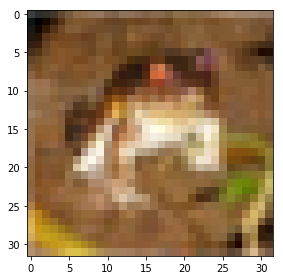

In [2]:
io.imshow(images[0])
plt.show()

In [3]:
img = np.array(images)

In [4]:
img.shape

(2000, 32, 32, 3)

In [7]:
from sklearn.metrics import make_scorer,f1_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
plt.style.use('ggplot')
Label = pd.read_excel('/Users/jiayinliu/Desktop/study/ML/proj6/finaldata/label.xlsx')
y = Label['label']
y.replace(to_replace = ['deer','frog','truck','bird','ship','airplane','horse','cat','automobile','dog'],
                 value = range(10), inplace = True)
y = np.array(Label['label'])

In [8]:
from sklearn.cross_validation import train_test_split
train_size = 0.8
test_size = 1 - train_size
x_train, x_test,y_train,y_test = train_test_split(img,y, train_size=train_size)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
import keras
from keras.datasets import cifar10
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import os

NUM_CLASSES = 10

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

print(x_train.shape)
print(y_train.shape)

(1600, 32, 32, 3)
(1600,)


In [10]:
%%time
from scipy.misc import imresize
x_train_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_train]
x_train_up = np.stack(x_train_up,axis=0)
print(x_train_up.shape)

x_test_up = [imresize(x,size=(224,224,3), interp='nearest') for x in x_test]
x_test_up = np.stack(x_test_up,axis=0)
print(x_test_up.shape)

/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


(1600, 224, 224, 3)
(400, 224, 224, 3)
CPU times: user 747 ms, sys: 286 ms, total: 1.03 s
Wall time: 1.14 s


/Users/jiayinliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [ ]:
from keras import applications
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

model = applications.VGG19(weights = "imagenet")
# connect new layers to the output
x = model.output
# let's add a fully-connected layer
x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=model.input, outputs=predictions)

# freeze ResNet during training
for layer in model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_up,y_train_ohe,epochs=1,batch_size=64,verbose=1)

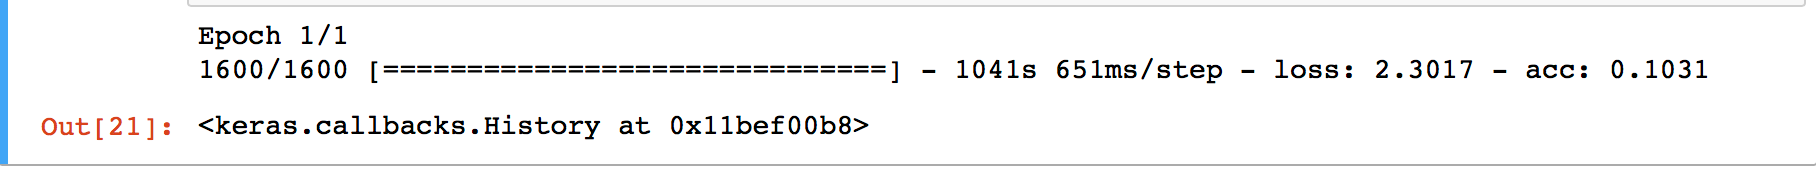

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, x_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(x_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [ ]:
summarize_net(model, x_test_up, y_test, title_text='Transfer Learning, VGG19:')

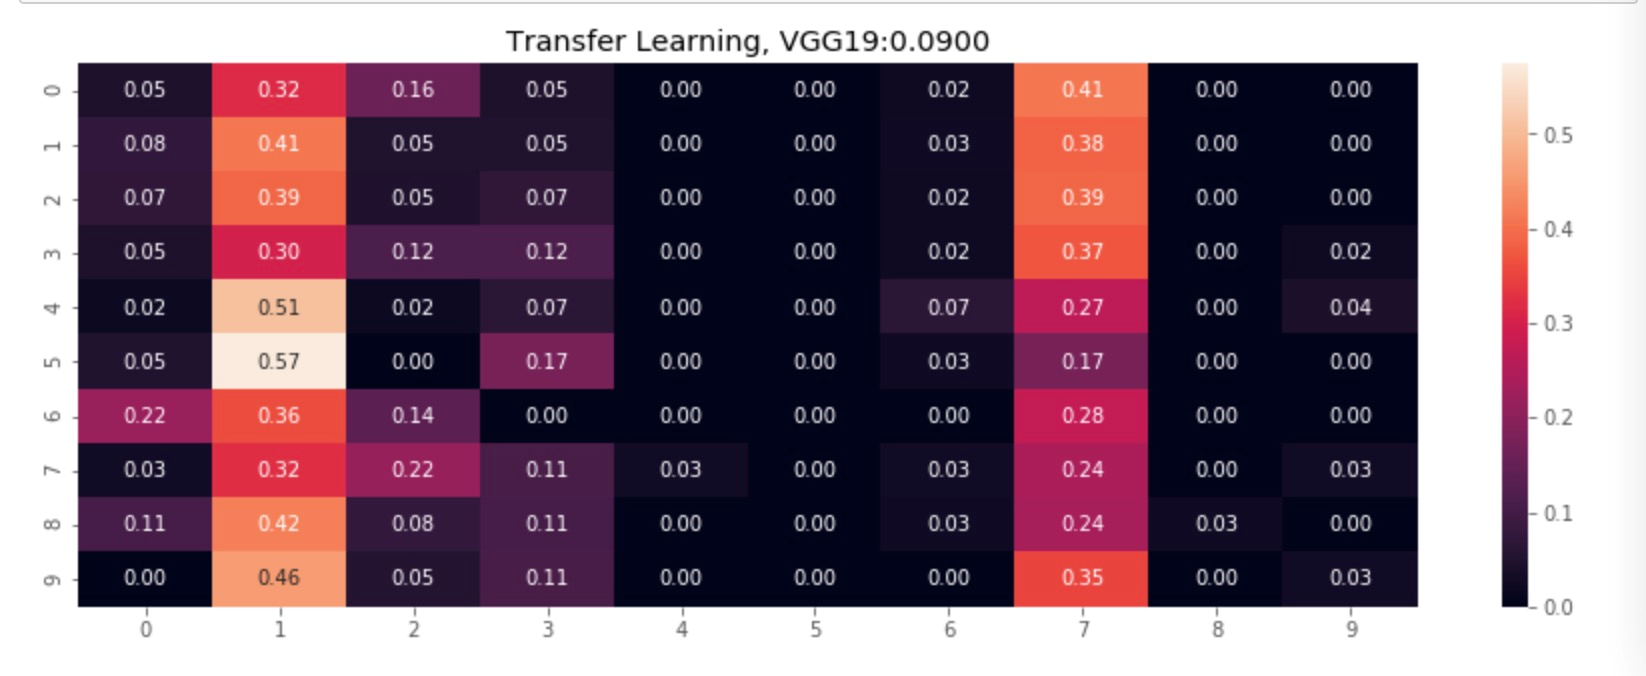

In [ ]:
from keras import applications
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.layers import average 
from keras.models import Input, Model

model = applications.VGG19(weights = "imagenet")
# connect new layers to the output
x = model.output
# let's add a fully-connected layer
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu',kernel_initializer='he_uniform')(x)
# and a fully connected layer 
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)

model = Model(inputs=model.input, outputs=predictions)

# freeze ResNet during training
for layer in model.layers:
    layer.trainable = False
    
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train_up,y_train_ohe,epochs=1,batch_size=64,verbose=1)

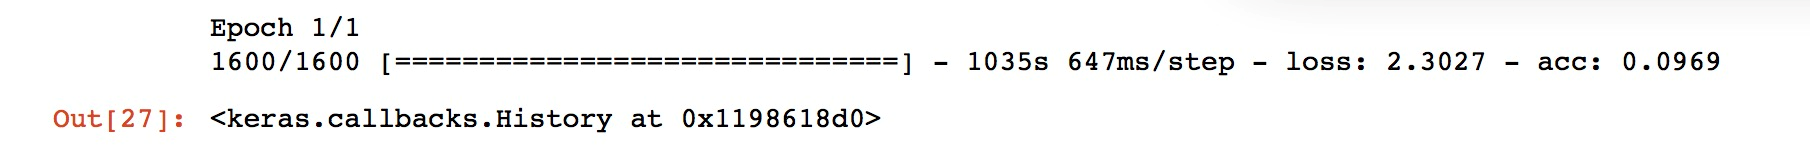

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, x_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(x_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [ ]:
summarize_net(model, x_test_up, y_test, title_text='Transfer Learning, VGG19:')

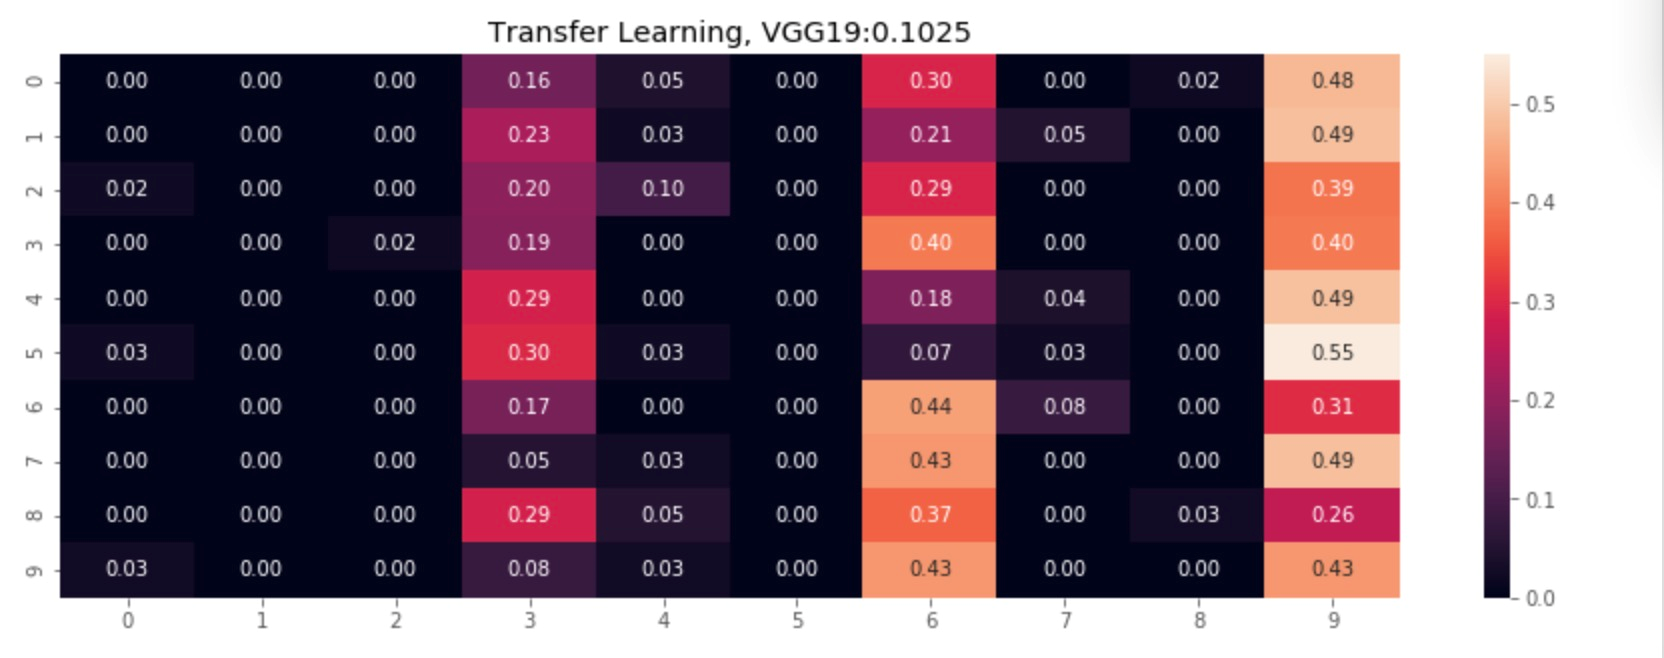

Keras supports 5 pre-trained models: Xception，VGG16，VGG19，ResNet50，InceptionV3，MobileNet, here we choose VGG19 to do transfer learning. VGG19 model provide pre-trained weights.

The default weights of VGG19 model is'imagenet',the default picture size is 224*224*3, so we try the default setting, resize the original pictures from 32*32*3, As the running time of every epoch is long, we set the epochs=1.then the accuracy is only 0.1031.Several reasons may lead to it.For example, the data train_size is too small, only 1600, at the same time, there exists many invalid pictures,and the epoch eaquals to 1,when it increases,the accuracy will increase.

Comparing to the accuracy 0.0844(1/10 epoch of two layers cnn), it's higher, although much slower. Comparing to the accuracy 0.2391(1/10 epoch of four layers cnn), it's lower, still much slower.

So for the customer layers, we add One more dense layer.The accuracy becomes 0.0969,changes little.

So to save time and resources,we prefer our own CNN,especially in the situation the pixels is small.

# Reference

https://github.com/eclarson/MachineLearningNotebooks  
  https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8  
  http://www.vision.caltech.edu/Image_Datasets/Caltech101/#Description  
  https://en.wikipedia.org/wiki/Cross-validation_(statistics)  
  Gareth James, Daniela Witten, Trevor Hastie, and Robert Tibshiranietc. An Introduction to Statistical Learning with Applications in R. Springer, 2013. 
